#Rebalancing Backtest DeFi Vault Strategy Comparison

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random
from scipy import stats

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

Simulation SETUP

In [ ]:
usdc_pools = pd.DataFrame([
    {'pool': 'GTEUSDC', 'apy': 9.66248, 'volatility': 0.8},
    {'pool': 'USDC', 'apy': 9.55101, 'volatility': 0.7},
    {'pool': 'HYPERUSDC', 'apy': 7.66315, 'volatility': 0.5},
    {'pool': 'REUSDC', 'apy': 7.08282, 'volatility': 0.6},
    {'pool': 'GTUSDCF', 'apy': 6.5868, 'volatility': 0.4},
    {'pool': 'IUSDC', 'apy': 6.1264, 'volatility': 0.3},
    {'pool': 'PIUSDC', 'apy': 5.9812, 'volatility': 0.35},
    {'pool': 'RUSDC', 'apy': 5.59018, 'volatility': 0.25}
])
# Convert APY from percentage to decimal for easier calculations
usdc_pools['apy'] = usdc_pools['apy'] / 100

# Display the pools we'll use for our simulation
print("USDC Pools for Simulation:")
display(usdc_pools)

USDC Pools for Simulation:


,pool,apy,volatility
0,GTEUSDC,0.096625,0.80
1,USDC,0.095510,0.70
2,HYPERUSDC,0.076632,0.50
3,REUSDC,0.070828,0.60
4,GTUSDCF,0.065868,0.40
5,IUSDC,0.061264,0.30
6,PIUSDC,0.059812,0.35
7,RUSDC,0.055902,0.25


In [ ]:
# Simulation time parameters
sim_days = 365  # One year simulation
rebalance_frequency = 1  # Rebalance every X days (1 = daily)

# Initial investment
initial_investment = 10000  # $10,000 USDC

# Transaction costs (as a percentage of moved funds)
tx_cost_percentage = 0.001  # 0.1% gas and slippage costs

# The fixed APY for the static strategy (mid-tier pool)
static_pool_idx = 4  # Using GTUSDCF pool with ~5.5% APY
static_pool = usdc_pools.iloc[static_pool_idx]

print(f"Static Strategy Pool: {static_pool['pool']} with initial APY: {static_pool['apy']*100:.2f}%")


Static Strategy Pool: GTUSDCF with initial APY: 6.59%


In [ ]:
# Function to simulate daily APY changes
def simulate_apy_changes(pools_df, days, volatility_scale=1.0):
    """
    Simulate daily changes to pool APYs based on volatility.

    Args:
        pools_df: DataFrame with pool info including 'apy' and 'volatility'
        days: Number of days to simulate
        volatility_scale: Scale factor for volatility

    Returns:
        DataFrame with daily APY values for each pool
    """
    # Initialize DataFrame to store daily APYs
    daily_apys = pd.DataFrame(index=range(days))

    # Initial APYs as day 0
    for i, row in pools_df.iterrows():
        daily_apys.loc[0, row['pool']] = row['apy']

    # Simulate APY changes for each day
    for day in range(1, days):
        for i, row in pools_df.iterrows():
            pool_name = row['pool']
            prev_apy = daily_apys.loc[day-1, pool_name]
            volatility = row['volatility'] * volatility_scale

            # Calculate daily change (mean-reverting random walk)
            # More volatile pools will have larger daily changes
            daily_change = np.random.normal(0, volatility * 0.0015)

            # Add some mean reversion to keep APYs within realistic bounds
            target_apy = row['apy']  # Mean reversion target is the initial APY
            mean_reversion = 0.02 * (target_apy - prev_apy)  # 2% daily reversion

            # Calculate new APY
            new_apy = prev_apy + daily_change + mean_reversion

            # Ensure APY stays positive and within reasonable bounds
            new_apy = max(0.001, min(new_apy, 0.15))  # Between 0.1% and 15%

            daily_apys.loc[day, pool_name] = new_apy

    return daily_apys


In [ ]:
def run_rebalancing_strategy(daily_apys, initial_value, rebalance_every=1, tx_cost=0.001):
    """
    Simulate a rebalancing strategy that moves to the highest APY pool.

    Args:
        daily_apys: DataFrame with daily APY values for each pool
        initial_value: Starting investment value
        rebalance_every: Rebalance frequency in days
        tx_cost: Transaction cost as a percentage

    Returns:
        DataFrame with daily portfolio value and current pool
    """
    days = len(daily_apys)

    # Initialize results
    results = pd.DataFrame(index=range(days))
    results['value'] = 0.0
    results['daily_return'] = 0.0
    results['pool'] = ''

    # Set initial values
    results.loc[0, 'value'] = initial_value

    # Find the highest APY pool for day 0
    best_pool = daily_apys.iloc[0].idxmax()
    results.loc[0, 'pool'] = best_pool

    # Simulate each day
    for day in range(1, days):
        prev_value = results.loc[day-1, 'value']
        current_pool = results.loc[day-1, 'pool']

        # Get daily APY (divide annual APY by 365)
        daily_apy = daily_apys.loc[day-1, current_pool] / 365

        # Calculate new value with compounding
        new_value = prev_value * (1 + daily_apy)

        # Record the daily return
        results.loc[day, 'daily_return'] = daily_apy

        # Check if we need to rebalance
        if day % rebalance_every == 0:
            # Find the best pool for today
            best_pool = daily_apys.iloc[day].idxmax()

            # Only rebalance if the best pool has changed
            if best_pool != current_pool:
                # Apply transaction cost
                tx_fee = new_value * tx_cost
                new_value -= tx_fee
                results.loc[day, 'pool'] = best_pool
            else:
                results.loc[day, 'pool'] = current_pool
        else:
            results.loc[day, 'pool'] = current_pool

        # Update the portfolio value
        results.loc[day, 'value'] = new_value

    return results

In [ ]:
def run_static_strategy(daily_apys, initial_value, pool_name):
    """
    Simulate a static strategy that stays in one pool.

    Args:
        daily_apys: DataFrame with daily APY values for each pool
        initial_value: Starting investment value
        pool_name: Name of the pool to stay in

    Returns:
        DataFrame with daily portfolio value
    """
    days = len(daily_apys)

    # Initialize results
    results = pd.DataFrame(index=range(days))
    results['value'] = 0.0
    results['daily_return'] = 0.0
    results['pool'] = pool_name

    # Set initial values
    results.loc[0, 'value'] = initial_value

    # Simulate each day
    for day in range(1, days):
        prev_value = results.loc[day-1, 'value']

        # Get daily APY (divide annual APY by 365)
        daily_apy = daily_apys.loc[day-1, pool_name] / 365

        # Calculate new value with compounding
        new_value = prev_value * (1 + daily_apy)

        # Record daily return
        results.loc[day, 'daily_return'] = daily_apy

        # Update the portfolio value
        results.loc[day, 'value'] = new_value

    return results

In [ ]:
def calculate_sharpe_ratio(returns, risk_free_rate=0.03/365):
    """
    Calculate the Sharpe ratio for a given set of returns.

    Args:
        returns: Series of daily returns
        risk_free_rate: Risk-free rate (default 3% annually, converted to daily)

    Returns:
        Sharpe ratio (annualized)
    """
    # Calculate excess returns
    excess_returns = returns - risk_free_rate

    # Calculate Sharpe ratio (annualized)
    sharpe = np.sqrt(365) * excess_returns.mean() / excess_returns.std()

    return sharpe



Simulating daily APY changes...


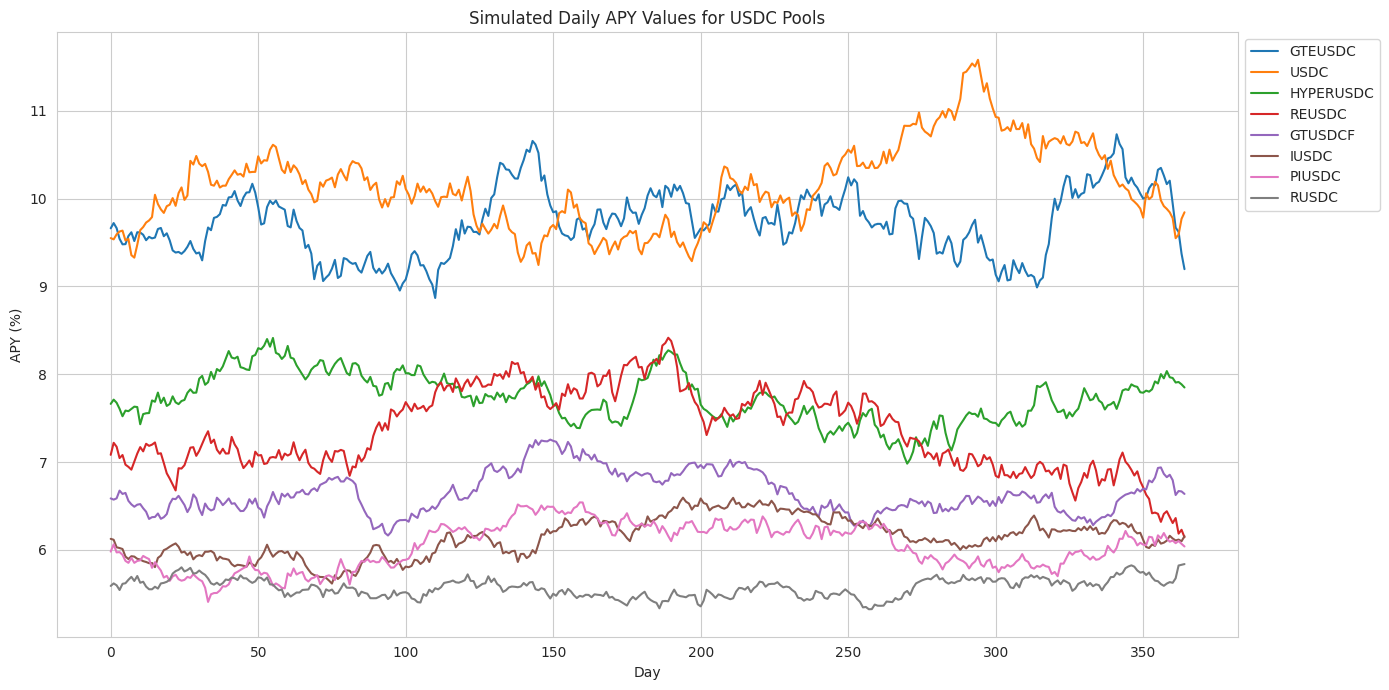


Running rebalancing strategy...
Running static strategy...


In [ ]:
print("\nSimulating daily APY changes...")
daily_apys = simulate_apy_changes(usdc_pools, sim_days)

# Plot the simulated APY changes for all pools
plt.figure(figsize=(14, 7))
for pool in daily_apys.columns:
    plt.plot(daily_apys[pool] * 100, label=pool)
plt.title('Simulated Daily APY Values for USDC Pools')
plt.xlabel('Day')
plt.ylabel('APY (%)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Run both strategies
print("\nRunning rebalancing strategy...")
rebalancing_results = run_rebalancing_strategy(
    daily_apys,
    initial_investment,
    rebalance_every=rebalance_frequency,
    tx_cost=tx_cost_percentage
)

print("Running static strategy...")
static_results = run_static_strategy(
    daily_apys,
    initial_investment,
    static_pool['pool']
)

In [ ]:
# Calculate final portfolio values
rebalancing_final = rebalancing_results['value'].iloc[-1]
static_final = static_results['value'].iloc[-1]

print(f"\nInitial Investment: ${initial_investment:,.2f}")
print(f"Final Value (Rebalancing): ${rebalancing_final:,.2f}")
print(f"Final Value (Static): ${static_final:,.2f}")
print(f"Difference: ${rebalancing_final - static_final:,.2f} ({((rebalancing_final/static_final)-1)*100:.2f}%)")

# Calculate performance metrics
# Annualized return
rebalancing_return = (rebalancing_final / initial_investment) - 1
static_return = (static_final / initial_investment) - 1

# Sharpe ratios
rebalancing_sharpe = calculate_sharpe_ratio(rebalancing_results['daily_return'])
static_sharpe = calculate_sharpe_ratio(static_results['daily_return'])

print(f"\nAnnualized Return (Rebalancing): {rebalancing_return*100:.2f}%")
print(f"Annualized Return (Static): {static_return*100:.2f}%")
print(f"Sharpe Ratio (Rebalancing): {rebalancing_sharpe:.2f}")
print(f"Sharpe Ratio (Static): {static_sharpe:.2f}")

# Calculate pool usage statistics for rebalancing strategy
pool_usage = rebalancing_results['pool'].value_counts()
print("\nPool Usage in Rebalancing Strategy:")
print(pool_usage)



Initial Investment: $10,000.00
Final Value (Rebalancing): $10,845.82
Final Value (Static): $10,685.62
Difference: $160.20 (1.50%)

Annualized Return (Rebalancing): 8.46%
Annualized Return (Static): 6.86%
Sharpe Ratio (Rebalancing): 207.34
Sharpe Ratio (Static): 164.88

Pool Usage in Rebalancing Strategy:
pool
USDC       260
GTEUSDC    105
Name: count, dtype: int64


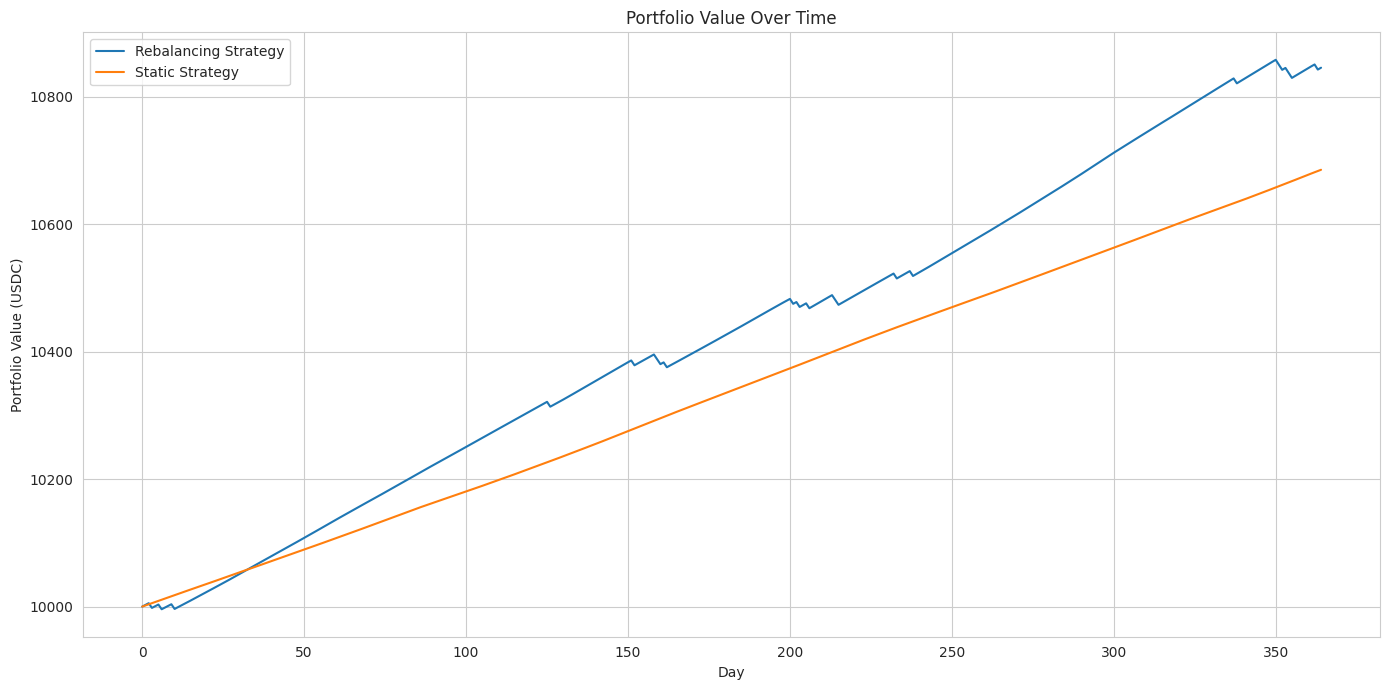

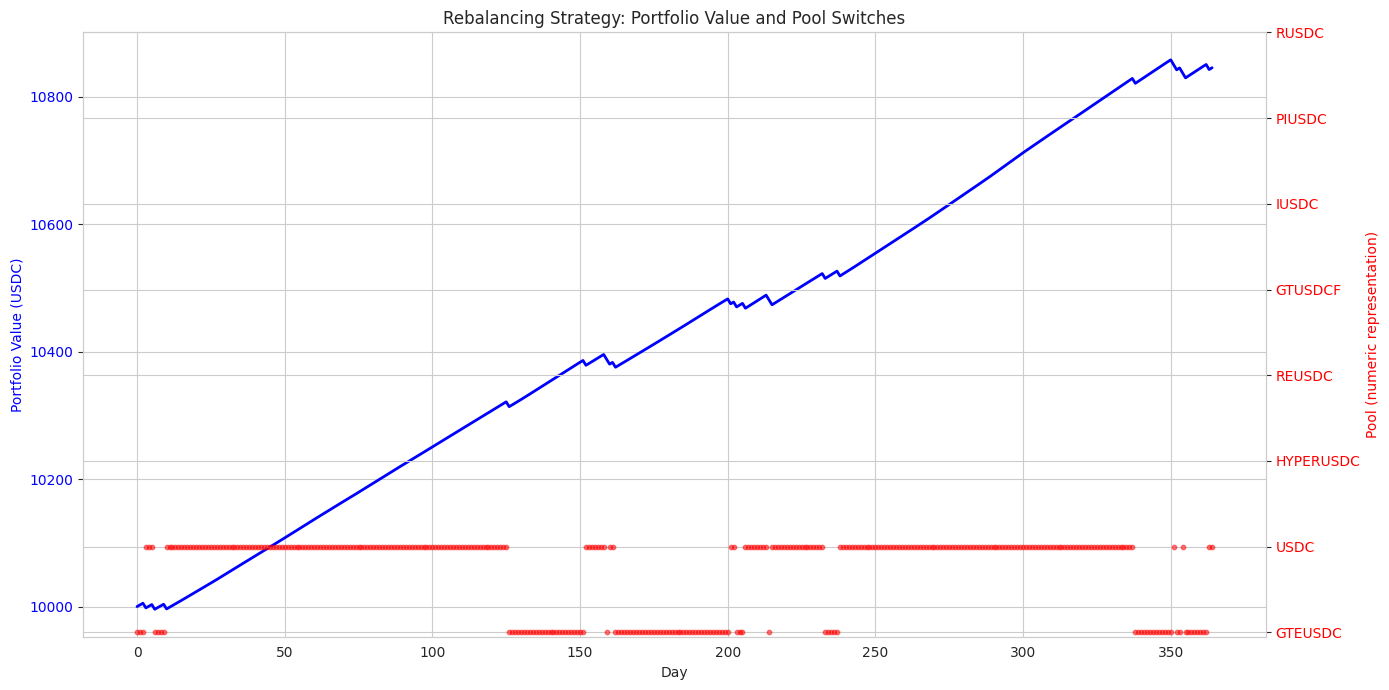

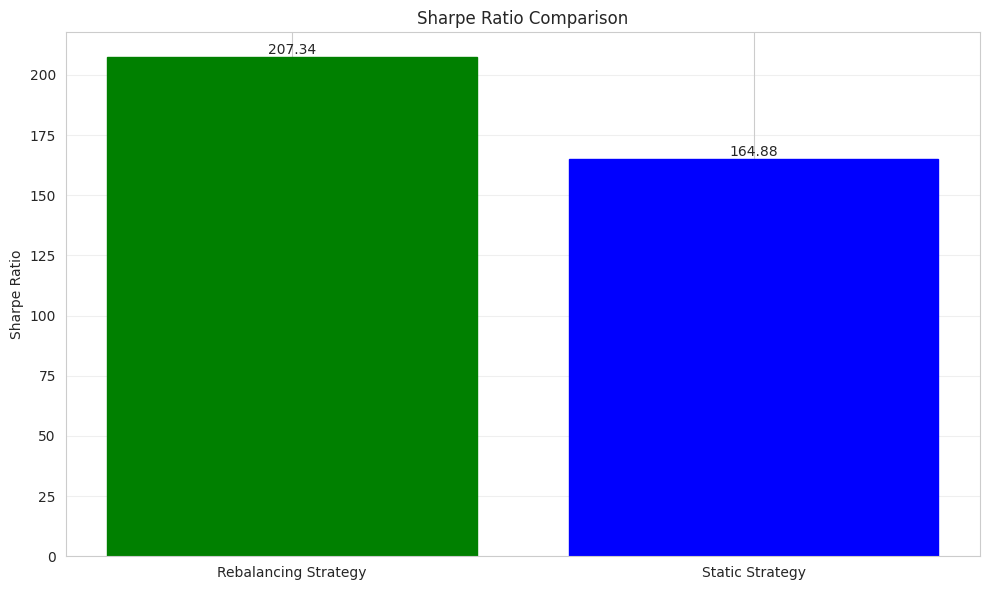

In [ ]:
# Plot portfolio value over time
plt.figure(figsize=(14, 7))
plt.plot(rebalancing_results['value'], label='Rebalancing Strategy')
plt.plot(static_results['value'], label='Static Strategy')
plt.title('Portfolio Value Over Time')
plt.xlabel('Day')
plt.ylabel('Portfolio Value (USDC)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Create a plot showing the pool switches for the rebalancing strategy
plt.figure(figsize=(14, 7))

# Plot the portfolio value
ax1 = plt.gca()
ax1.plot(rebalancing_results['value'], color='blue', linewidth=2)
ax1.set_xlabel('Day')
ax1.set_ylabel('Portfolio Value (USDC)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis to show the pool switches
ax2 = ax1.twinx()
pool_numeric = pd.factorize(rebalancing_results['pool'])[0]
ax2.scatter(rebalancing_results.index, pool_numeric, c='red', alpha=0.5, s=10)
ax2.set_ylabel('Pool (numeric representation)', color='red')
ax2.set_yticks(range(len(usdc_pools)))
ax2.set_yticklabels(usdc_pools['pool'])
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Rebalancing Strategy: Portfolio Value and Pool Switches')
plt.tight_layout()
plt.show()

# Sharpe Ratio Comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(['Rebalancing Strategy', 'Static Strategy'], [rebalancing_sharpe, static_sharpe])
bars[0].set_color('green')
bars[1].set_color('blue')
plt.title('Sharpe Ratio Comparison')
plt.ylabel('Sharpe Ratio')
plt.grid(axis='y', alpha=0.3)

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

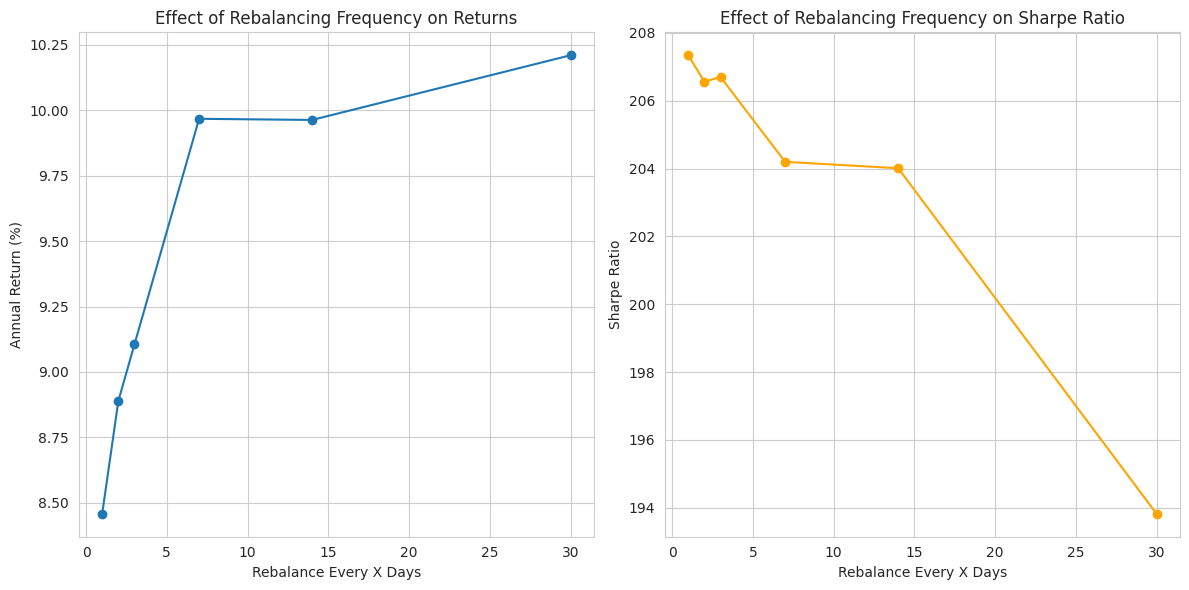

In [ ]:
# Let's test how the rebalancing frequency affects performance
frequencies = [1, 2, 3, 7, 14, 30]  # days
frequency_results = []

for freq in frequencies:
    result = run_rebalancing_strategy(
        daily_apys,
        initial_investment,
        rebalance_every=freq,
        tx_cost=tx_cost_percentage
    )
    final_value = result['value'].iloc[-1]
    sharpe = calculate_sharpe_ratio(result['daily_return'])
    frequency_results.append({
        'frequency': freq,
        'final_value': final_value,
        'return': (final_value / initial_investment) - 1,
        'sharpe': sharpe
    })

# Convert to DataFrame
freq_df = pd.DataFrame(frequency_results)

# Plot the effect of rebalancing frequency on returns
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(freq_df['frequency'], freq_df['return'] * 100, marker='o')
plt.title('Effect of Rebalancing Frequency on Returns')
plt.xlabel('Rebalance Every X Days')
plt.ylabel('Annual Return (%)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(freq_df['frequency'], freq_df['sharpe'], marker='o', color='orange')
plt.title('Effect of Rebalancing Frequency on Sharpe Ratio')
plt.xlabel('Rebalance Every X Days')
plt.ylabel('Sharpe Ratio')
plt.grid(True)

plt.tight_layout()
plt.show()

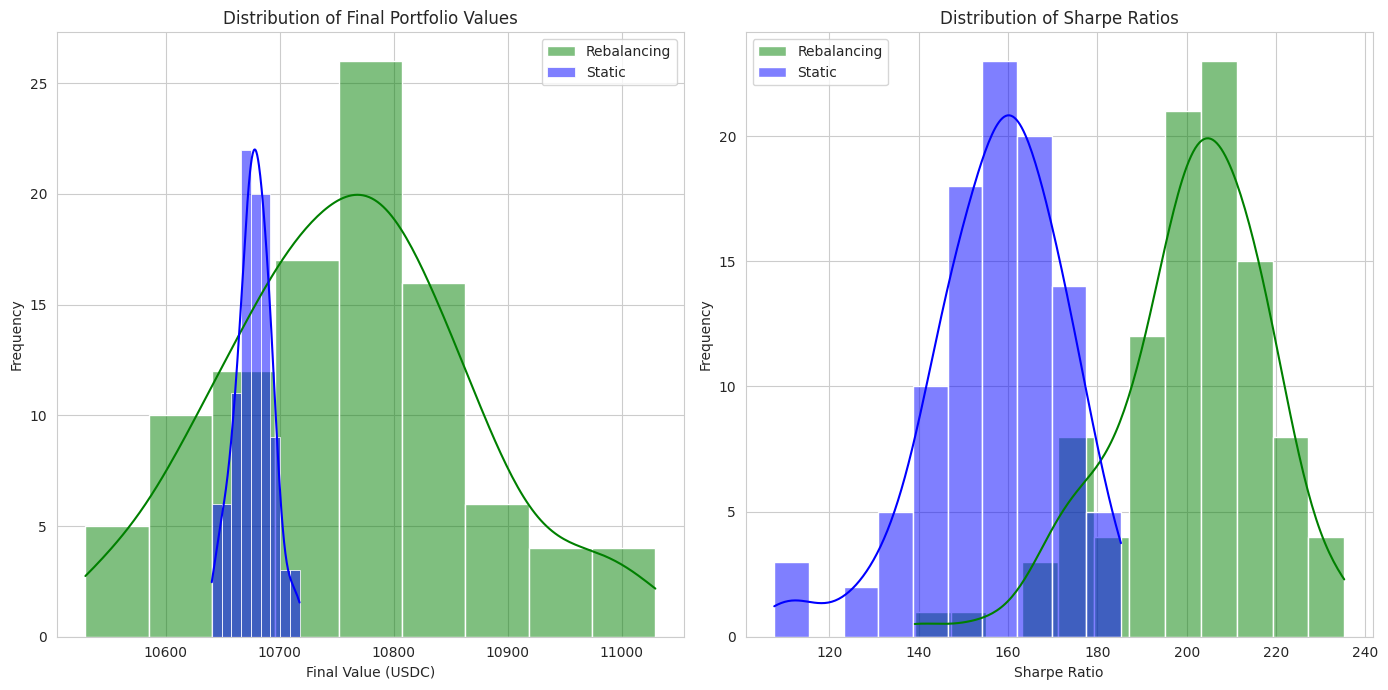


Probability of Rebalancing Strategy Outperforming Static Strategy: 79.00%
Average Outperformance of Rebalancing Strategy: 0.79%


In [ ]:
# Monte Carlo Simulation
# -----------------------------------------------------------------------------------

# Let's run multiple simulations to get a distribution of outcomes
num_simulations = 100
rebalancing_final_values = []
static_final_values = []
rebalancing_sharpes = []
static_sharpes = []

for i in range(num_simulations):
    # Create a new random seed for each simulation
    seed = np.random.randint(1, 10000)
    np.random.seed(seed)
    random.seed(seed)

    # Simulate new APY changes
    daily_apys_sim = simulate_apy_changes(usdc_pools, sim_days, volatility_scale=np.random.uniform(0.8, 1.2))

    # Run both strategies
    rebalancing_results_sim = run_rebalancing_strategy(
        daily_apys_sim,
        initial_investment,
        rebalance_every=rebalance_frequency,
        tx_cost=tx_cost_percentage
    )

    static_results_sim = run_static_strategy(
        daily_apys_sim,
        initial_investment,
        static_pool['pool']
    )

    # Record final values
    rebalancing_final_values.append(rebalancing_results_sim['value'].iloc[-1])
    static_final_values.append(static_results_sim['value'].iloc[-1])

    # Record Sharpe ratios
    rebalancing_sharpes.append(calculate_sharpe_ratio(rebalancing_results_sim['daily_return']))
    static_sharpes.append(calculate_sharpe_ratio(static_results_sim['daily_return']))

# Plot distribution of final values
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.histplot(rebalancing_final_values, kde=True, color='green', label='Rebalancing')
sns.histplot(static_final_values, kde=True, color='blue', label='Static')
plt.title('Distribution of Final Portfolio Values')
plt.xlabel('Final Value (USDC)')
plt.ylabel('Frequency')
plt.legend()

# Plot distribution of Sharpe ratios
plt.subplot(1, 2, 2)
sns.histplot(rebalancing_sharpes, kde=True, color='green', label='Rebalancing')
sns.histplot(static_sharpes, kde=True, color='blue', label='Static')
plt.title('Distribution of Sharpe Ratios')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Calculate probability of rebalancing outperforming static strategy
outperformance_probability = sum(r > s for r, s in zip(rebalancing_final_values, static_final_values)) / num_simulations
print(f"\nProbability of Rebalancing Strategy Outperforming Static Strategy: {outperformance_probability*100:.2f}%")

# Calculate average outperformance
average_outperformance = np.mean([(r/s - 1)*100 for r, s in zip(rebalancing_final_values, static_final_values)])
print(f"Average Outperformance of Rebalancing Strategy: {average_outperformance:.2f}%")


In [ ]:
print("\n=== SUMMARY OF FINDINGS ===")
print(f"1. The rebalancing strategy that switches to the highest APY pool daily yielded a {rebalancing_return*100:.2f}% return,")
print(f"   compared to {static_return*100:.2f}% for the static strategy.")
print(f"2. Rebalancing improved the Sharpe ratio from {static_sharpe:.2f} to {rebalancing_sharpe:.2f}, indicating better risk-adjusted returns.")
print(f"3. The optimal rebalancing frequency appears to be every {freq_df.loc[freq_df['sharpe'].idxmax(), 'frequency']:.0f} days based on maximizing the Sharpe ratio.")
print(f"4. Monte Carlo simulations show the rebalancing strategy outperforms the static strategy {outperformance_probability*100:.1f}% of the time.")
print(f"5. The average outperformance of the rebalancing strategy is {average_outperformance:.2f}%.")
print("\nNote: This simulation includes transaction costs of {0.1:.2f}% per rebalance but does not account for other factors like")
print("impermanent loss or smart contract risks. Further refinements to the model could include these factors.")

# Create a summary table of both strategies
summary_df = pd.DataFrame({
    'Metric': ['Final Value ($)', 'Annual Return (%)', 'Sharpe Ratio', 'Outperformance Probability (%)', 'Average Outperformance (%)'],
    'Rebalancing Strategy': [f"{rebalancing_final:.2f}", f"{rebalancing_return*100:.2f}", f"{rebalancing_sharpe:.2f}", f"{outperformance_probability*100:.1f}", f"{average_outperformance:.2f}"],
    'Static Strategy': [f"{static_final:.2f}", f"{static_return*100:.2f}", f"{static_sharpe:.2f}", "N/A", "N/A"]
})

# Display the summary table
print("\nStrategy Comparison Summary:")
display(summary_df)


=== SUMMARY OF FINDINGS ===
1. The rebalancing strategy that switches to the highest APY pool daily yielded a 8.46% return,
   compared to 6.86% for the static strategy.
2. Rebalancing improved the Sharpe ratio from 164.88 to 207.34, indicating better risk-adjusted returns.
3. The optimal rebalancing frequency appears to be every 1 days based on maximizing the Sharpe ratio.
4. Monte Carlo simulations show the rebalancing strategy outperforms the static strategy 79.0% of the time.
5. The average outperformance of the rebalancing strategy is 0.79%.

Note: This simulation includes transaction costs of {0.1:.2f}% per rebalance but does not account for other factors like
impermanent loss or smart contract risks. Further refinements to the model could include these factors.

Strategy Comparison Summary:


,Metric,Rebalancing Strategy,Static Strategy
0,Final Value ($),10845.82,10685.62
1,Annual Return (%),8.46,6.86
2,Sharpe Ratio,207.34,164.88
3,Outperformance Probability (%),79.0,N/A
4,Average Outperformance (%),0.79,N/A
